In [263]:
import pandas as pd
import random
import numpy as np
##\
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [842]:
#Generates list of liked and disliked movies for each user
ratings_pd = pd.read_csv("./data/ratings_clean.csv")
movied_pd = pd.read_csv("./data/movies_clean.csv", index_col=["movieId"], header=0)

train_seqs = ratings_pd.groupby('userId')['movieId'].agg(list)
index_pd = ratings_pd.set_index(["userId", "movieId"])

us_rate_perc = dict()

#Creates Map <user_id , [upper, lower]>
for user_id in range(ratings_pd["userId"].nunique()):
    rating = index_pd.loc[user_id]
    us_rate_perc[user_id] = [[rating["rating"].quantile(q=0.70)],[ rating["rating"].quantile(q=0.50)]]



In [843]:
#Generates list of liked and disliked movies for each user
user_ratings = dict()

#Creates Map <user_id , [pos_list, neg_list]>
for user_id,movie_list in train_seqs.items() :
    pos_samples = []
    neg_samples = []
    for movie_id in movie_list:
        rating = index_pd.loc[user_id].loc[movie_id].values[0]
        if rating >= us_rate_perc[user_id][0]: pos_samples.append(movie_id)
        elif rating < us_rate_perc[user_id][1]: neg_samples.append(movie_id)
        else: pass
    user_ratings[user_id] = [pos_samples, neg_samples]


In [879]:
from collections import defaultdict
def def_value():
    return 0
#Generate positives samples
#movies[0] = pos
#movies[1] = neg
#generates pos_samples = tuple of positive pair w/ user_id
pos_samples = []
pos_freq = defaultdict(def_value)

for user_id,movies in user_ratings.items():
    for i in range(len(movies[0])):
        movie_id = movies[0][i]
        for j in range(len(movies[0])):
            if i == j : continue
            pos_samples.append([i,j,user_id])
            pos_freq[i] +=1



In [880]:
print(len(pos_samples))
#build pos sample freq map

1170924


In [888]:
samples = []
rho = 0.002
neg_sample_c = 10
for sample in pos_samples:
    frac = pos_freq[sample[0]] / len(pos_samples)
    prob = (np.sqrt(frac/rho) + 1) * (rho/frac)
    if np.random.random() >= prob: continue

    neg_list = user_ratings[sample[2]][1]
    if len(neg_list) == 0 :
        continue
    target = sample[0]
    context = [sample[1]]
    labels = [1]
    for i in range(neg_sample_c):
        context.append(random.choice(neg_list))
        labels.append(0)
    samples.append([target, context, labels])

In [889]:
print(len(samples))
# print(samples[:100])

840329


In [890]:
args = {
    "batch_size" : 256,
    "embedding_size" : 256,
    "epoch": 1,
    "lr": 0.1,
    }

movies_size= len(movied_pd)
user_size = ratings_pd["userId"].nunique()


In [891]:
class ItemDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        target = torch.tensor(self.data[index][0], dtype=torch.long)
        context = torch.tensor(self.data[index][1], dtype=torch.long)
        label = torch.tensor(self.data[index][2], dtype=torch.float32)

        return target, context, label

    def __len__(self):
        return len(self.data)
#split samples here
item_dataset = ItemDataset(samples)
train_loader = DataLoader(item_dataset, batch_size=args["batch_size"], shuffle=True)
loss_vals = []
acc_vals = []

In [892]:
class ItemVectorModel(nn.Module):
    def __init__(self, args):
        super(ItemVectorModel, self).__init__()
        self.shared_embedding = nn.Embedding(movies_size, args["embedding_size"])
        self.activation = nn.Sigmoid()

    def forward(self, target, context):
        context_emb = self.shared_embedding(context)
        movie_emb = self.shared_embedding(target)
        dots = torch.einsum('be,bce->bc', movie_emb, context_emb)
        return dots
        
    def fit(self, train_loader, epoch=args["epoch"], lr=args["lr"]):
        self.train()
        optimizer = optim.Adam(self.parameters())
        loss_func = nn.BCEWithLogitsLoss()

        for i in range(1, epoch+1):
            #target.shape batch, : context.shape batch x neg_c ; label.shape = batch x neg_c
            correct = 0
            total = 0
            iter = 0
            for target, context, label in train_loader:
                self.zero_grad()
                prediction = self.forward(target, context)
                loss = loss_func(prediction, label)
                loss.backward()
                optimizer.step()
   
                iter += 1
                if iter % 500 == 0 :
                    loss_vals.append(loss.item())
                    print(f"iter {iter}/{len(train_loader)} loss: {loss.item()}", end='\r')
                    with torch.no_grad():
                        pred = torch.argmax(self.activation(prediction), dim=1)
                        lbl = torch.argmax(self.activation(label), dim=1)
                        total += lbl.size(0)
                        correct += (pred == lbl).sum().item()
                        acc_vals.append(100 * correct / total)
            accuracy = 100 * correct / total
            print(f"epoch {i}/{epoch} loss: {loss.item()}\taccuracy: {accuracy}")


In [893]:
model = ItemVectorModel(args)

In [899]:
model.fit(train_loader, epoch=15)

epoch 1/15 loss: 0.2902439832687378	accuracy: 32.2265625
epoch 2/15 loss: 0.30256563425064087	accuracy: 33.268229166666664
epoch 3/15 loss: 0.30190911889076233	accuracy: 31.640625
epoch 4/15 loss: 0.29746243357658386	accuracy: 33.723958333333336
epoch 5/15 loss: 0.31604528427124023	accuracy: 31.25
epoch 6/15 loss: 0.3011314868927002	accuracy: 30.6640625
epoch 7/15 loss: 0.30022960901260376	accuracy: 30.338541666666668
epoch 8/15 loss: 0.292299747467041	accuracy: 32.877604166666664
epoch 9/15 loss: 0.32078588008880615	accuracy: 31.0546875
epoch 10/15 loss: 0.3161046504974365	accuracy: 30.403645833333332
epoch 11/15 loss: 0.33998429775238037	accuracy: 30.729166666666668
epoch 12/15 loss: 0.28984934091567993	accuracy: 32.291666666666664
epoch 13/15 loss: 0.2999739944934845	accuracy: 32.2265625
epoch 14/15 loss: 0.2880609333515167	accuracy: 33.268229166666664
epoch 15/15 loss: 0.30175185203552246	accuracy: 31.4453125


In [735]:
def ranking(query_liked, query_disliked):
    with torch.no_grad():
        weights = model.activation(model.shared_embedding.weight.detach()).numpy()
        query_res = weights[query_liked].sum(axis=0)
        if(len(query_disliked) > 0):
            query_res = np.subtract(query_res, weights[query_disliked].sum(axis=0))
        outs = list()
        for idx,movie in movied_pd["title"].items():
            movie = weights[idx]
            vector_dot = np.dot(movie, query_res)
            movie_1_length = np.linalg.norm(movie,2)
            query_length = np.linalg.norm(query_res,2)
            cosine_dist =  (vector_dot / (movie_1_length * query_length))
            # print(outs)
            outs.append(cosine_dist)
        return torch.tensor(np.stack(outs,0))

In [820]:
def display_top_k(score, indices, k=5):
    top_scores = score[:k]
    top_indic = indices[:k]
    top_names = []
    top_generes = []

    for movie_id in top_indic:
        top_names.append(movied_pd.loc[movie_id.item()]["title"])
        top_generes.append(movied_pd.loc[movie_id.item()]["genres"])
        
    df = pd.DataFrame({
        "score_key": top_scores.numpy(),
        'titles':top_names,
        'genres': top_generes
    })
    print(df)

In [900]:
query_liked = [404, 394]
query_disliked = [391]
topk = 10

print("===========COSINE SIMILARITY===================")
score, indices = ranking(query_liked,query_disliked).sort(descending=True)
display_top_k(score,indices, topk)



===========COSINE SIMILARITY===================
   score_key                                             titles  \
0   0.979134                                 Toy Story 3 (2010)   
1   0.969772                                Total Recall (1990)   
2   0.969547                                       Dogma (1999)   
3   0.969362                          Lady and the Tramp (1955)   
4   0.968925                                American Pie (1999)   
5   0.968534  Chronicles of Narnia: The Lion, the Witch and ...   
6   0.968345                                 Unbreakable (2000)   
7   0.967950                    Honey, I Shrunk the Kids (1989)   
8   0.967545                                 I Am Legend (2007)   
9   0.966606                            Mr. & Mrs. Smith (2005)   

                                             genres  
0  Adventure|Animation|Children|Comedy|Fantasy|IMAX  
1                  Action|Adventure|Sci-Fi|Thriller  
2                          Adventure|Comedy|Fantasy 

C:\Users\Nicholas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Nicholas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


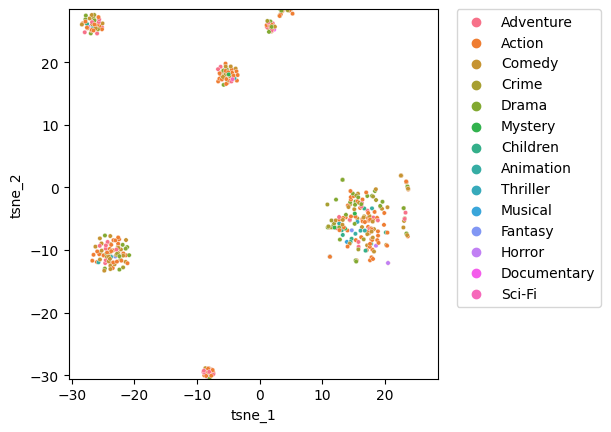

In [901]:
# %%
import numpy as np
import matplotlib.pylab as plt
from sklearn.manifold import TSNE
import seaborn as sns

%matplotlib inline
def onpick(event):
    # ... process selected item
    print("Picked!")

n_components = 2
tsne = TSNE(n_components)
model_normalized_space = model.activation(model.shared_embedding.weight.detach())
tsne_result = tsne.fit_transform(model_normalized_space)
tsne_result.shape
y =  movied_pd["genres"].map(lambda x : x.split('|')[0])
# y =  movied_pd["title"]

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y})
fig, ax = plt.subplots(1)
axx = sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=10)
lim = (tsne_result.min(), tsne_result.max())
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

# # %%
# x = model.embedding_space.weight[:,0]
# y = model.embedding_space.weight[:,1]
# plt.scatter(x.detach(),y.detach())

Text(0.5, 1.0, 'accuracy')

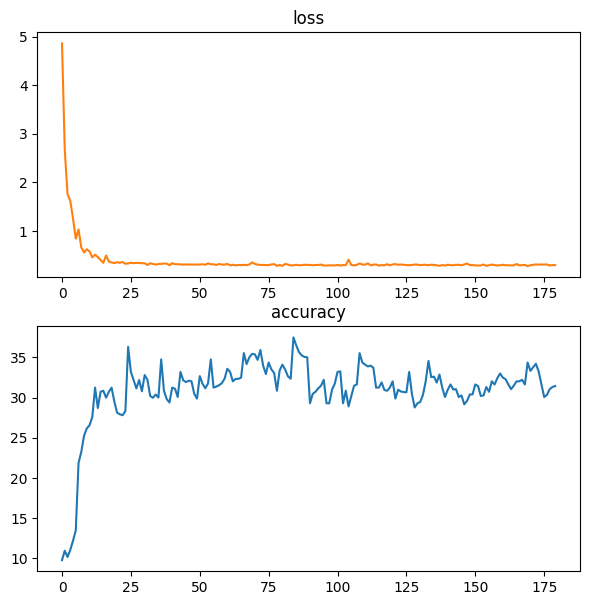

In [902]:
import matplotlib.pylab as plt
fig, axs = plt.subplots(2,figsize=(7, 7))
# fig.suptitle('Vertically stacked subplots')
axs[0].plot(loss_vals, 'tab:orange')
axs[0].set_title('loss')

axs[1].plot(acc_vals, label="accuracy")
axs[1].set_title('accuracy')

# plt.plot(loss_vals, label = "loss")
# plt.plot(acc_vals, label = "accuracy")

In [903]:
torch.save(model.state_dict(), 'model_pytorch3.h5')